# VDOT Project Development Data Exercise
# Dylan Howe

### Intent: Identify projects at risk of finishing development late based on descriptive factors of the project rather than milestone progression. 

### Please see the bottom of this document for results, interpretation, takeaways, and improvements.
<br>
The intent of this exercise is not to create the perfect predictive model or explore all aspects of VDOT's project development program, just to inspect the data and explore the viability of predicting on-time performance using information about the work being done.

In [1]:
#import dependencies
import numpy as np
import pandas as pd
import seaborn as sns

### Pull project data in from VDOT's public-facing Dashboard4

In [2]:
dev_df = pd.read_excel('https://www.virginiadot.org/dashboard/documents/Project_Export_Dashboard4.xlsx', 
                       sheet_name = 'Project_Development (UPC)')

#Dashboard Export includes rail and DRPT projects, we only want Local and VDOT
dev_df = dev_df[dev_df['ADMINISTERED_BY'].isin(['VDOT', 'Locally'])]

dev_df.head(3)

C:\Anaconda\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,UPC,DESCRIPTION,ROUTE,ROAD_SYSTEM,SCOPE_OF_WORK,ADMINISTERED_BY,CITY_COUNTY,RESIDENCY,DISTRICT,MPO,...,SOLICIT_BIDS_80_STATUS,START_DLVR_84_PLND_START_DT,START_DLVR_84_ACT_START_DT,START_DLVR_84_PLND_END_DT,START_DLVR_84_ACT_END_DT,START_DELIVERY_84_STATUS,DASHBOARD_COMMENT,GENERATED_DATE,REFRESHED_DATE,ACCOMPLISHMENT
0,98956,RTE 761 ??? Replace Bridge 05453 & Appr over O...,0761,Secondary,Bridge Replacement w/ Added Capacity,VDOT,Clarke County,EDINBURG,Staunton,NonMPO:NonMPO,...,G,2024-04-01,NaT,2024-04-30,NaT,G,NaN,2021-02-21 11:00:12,2021-02-21 06:04:15,RAAP CONTRACT
1,103262,Tyson East Sidewalk South Side of Route 123 -...,0123,Primary,Facilities for Pedestrians and Bicycles,Locally,Fairfax County,FAIRFAX,Northern Virginia,Northern Virginia:Fairfax County,...,G,2019-09-17,2019-01-15,2020-06-22,2019-04-15,G,NaN,2021-02-21 11:00:12,2021-02-21 06:04:15,NON VDOT
2,106490,POTOMAC HERITAGE TRAIL AT FEATHERSTONE WILDLIF...,0006,Miscellaneous,Facilities for Pedestrians and Bicycles,Locally,Prince William County,MANASSAS,Northern Virginia,Northern Virginia:Prince William County,...,R,2018-11-07,NaT,2019-04-30,NaT,R,Project advertisement is still underway,2021-02-21 11:00:12,2021-02-21 06:04:15,NON VDOT


In [3]:
#The project development data has almost 100 columns, mostly relating to its milestones and statuses
print(f'There are {len(dev_df.columns)} columns')

There are 95 columns


Based on subject area knowledge, many fields are not related to project performance, such as the generated date, UPC, project manager and contact information, etc.<br>

Milestone-level information is useful, but beyond the scope of this exercise. Description would be useful to break out keywords in the future. <br>

We will drop the extra columns, leaving only project information and the START_DELIVERY_84_ACT_END_DT, which is an indicator of whether the project has completed development already or not.

In [4]:
#Trim off all columns relating to milestones and the export filing date
cols = dev_df.columns[31:]
dev_trimmed = dev_df.drop(columns = cols)

#Manually drop the columns that aren't details about the work being done
dev_trimmed = dev_trimmed.drop(columns = ['UPC', 'DASHBOARD_CONTACT', 'DASHBOARD_CONTACT_EMAIL',
       'DASHBOARD_CONTACT_PHONE', 'VDOT_PROJECT_MANAGER',
       'VDOT_PROJECT_MANAGER_EMAIL', 'VDOT_PROJECT_MANAGER_PHONE',
       'NON_VDOT_PROJECT_MANAGER', 'NON_VDOT_PROJECT_MANAGER_EMAIL',
       'NON_VDOT_PROJECT_MANAGER_PHONE', 'PROJECT_STATUS', 'ON_TIME_STATUS_REASON', 'ON_BUDGET_STATUS_REASON',
        'ON_BUDGET_STATUS', 'DESCRIPTION', "FISCAL_YEAR"])

print(dev_trimmed.columns)

Index(['ROUTE', 'ROAD_SYSTEM', 'SCOPE_OF_WORK', 'ADMINISTERED_BY',
       'CITY_COUNTY', 'RESIDENCY', 'DISTRICT', 'MPO', 'PROGRAM_MANAGER',
       'SMART_SCALE_INDICATOR', 'SMARTSCALE_COHORT',
       'STATE_OF_GOOD_REPAIR_INDICATOR', 'BUDGET', 'ESTIMATE',
       'ON_TIME_STATUS'],
      dtype='object')


In [5]:
#Add back in a binary flag whether the project has completed development or not
#If the project has a date for its 'start delivery 84 actual end date', then we know it has finished development

#Had trouble iterating to check if end date was null, so I filled nulls with a string 'none' then iterated
none = dev_df['START_DLVR_84_ACT_END_DT'].fillna('none')

#list comprehension to map the new list to a binary and add to the trimmed df
dev_trimmed['COMPLETED_DEV'] = [0 if x == 'none'  else 1 for x in none]

dev_trimmed.head(3)

,ROUTE,ROAD_SYSTEM,SCOPE_OF_WORK,ADMINISTERED_BY,CITY_COUNTY,RESIDENCY,DISTRICT,MPO,PROGRAM_MANAGER,SMART_SCALE_INDICATOR,SMARTSCALE_COHORT,STATE_OF_GOOD_REPAIR_INDICATOR,BUDGET,ESTIMATE,ON_TIME_STATUS,COMPLETED_DEV
0,0761,Secondary,Bridge Replacement w/ Added Capacity,VDOT,Clarke County,EDINBURG,Staunton,NonMPO:NonMPO,Infrastructure Investment Division,0,NaN,0,4355591.0,4355591.0,R,0
1,0123,Primary,Facilities for Pedestrians and Bicycles,Locally,Fairfax County,FAIRFAX,Northern Virginia,Northern Virginia:Fairfax County,Infrastructure Investment Division,0,NaN,0,3120000.0,2646633.0,G,1
2,0006,Miscellaneous,Facilities for Pedestrians and Bicycles,Locally,Prince William County,MANASSAS,Northern Virginia,Northern Virginia:Prince William County,Infrastructure Investment Division,0,NaN,0,750000.0,750000.0,R,0


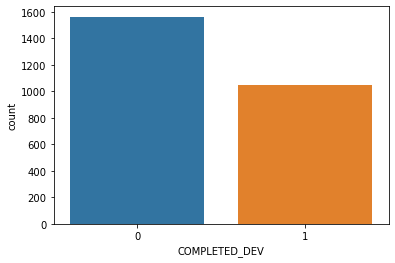

In [6]:
#How many projects have finished development vs are currently in development?
sns.countplot(dev_trimmed['COMPLETED_DEV'])

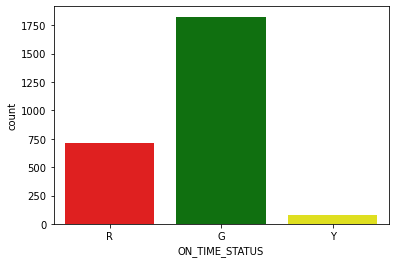

In [7]:
#How many projects are red/yellow/green for on-time?
clrs = ['red', 'green', 'yellow']
sns.countplot(dev_trimmed['ON_TIME_STATUS'], palette = clrs)

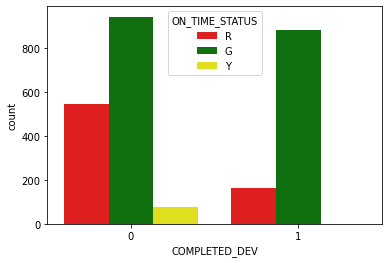

In [8]:
#How do completed projects compare to in development projects for on-time?
sns.countplot(x='COMPLETED_DEV', hue='ON_TIME_STATUS', palette = clrs, data=dev_trimmed)

#Completed projects have a lower proportion of reds to greens than active projects
#This could indicate that active red projects tend to recover before award, or that the program is declining as a whole

## Preprocessing data for modeling

In [9]:
#look at the current data types of the columns
dev_trimmed.dtypes

ROUTE                              object
ROAD_SYSTEM                        object
SCOPE_OF_WORK                      object
ADMINISTERED_BY                    object
CITY_COUNTY                        object
RESIDENCY                          object
DISTRICT                           object
MPO                                object
PROGRAM_MANAGER                    object
SMART_SCALE_INDICATOR               int64
SMARTSCALE_COHORT                 float64
STATE_OF_GOOD_REPAIR_INDICATOR      int64
BUDGET                            float64
ESTIMATE                          float64
ON_TIME_STATUS                     object
COMPLETED_DEV                       int64
dtype: object

In [10]:
#need to convert the columns to the correct datatypes, indicators are boolean, smart scale cohort is categorical

# using dictionary to convert specific columns 
convert_dict = {
    'SMART_SCALE_INDICATOR': bool,
    'SMARTSCALE_COHORT': str,
    'STATE_OF_GOOD_REPAIR_INDICATOR': bool,
    'COMPLETED_DEV': bool
               } 
  
dev_trimmed = dev_trimmed.astype(convert_dict) 

In [11]:
#Look at the number of categories we'll have to create for one-hot encoding
dev_trimmed.nunique()

ROUTE                              445
ROAD_SYSTEM                          7
SCOPE_OF_WORK                       26
ADMINISTERED_BY                      2
CITY_COUNTY                        221
RESIDENCY                           31
DISTRICT                            10
MPO                                 93
PROGRAM_MANAGER                      4
SMART_SCALE_INDICATOR                2
SMARTSCALE_COHORT                    5
STATE_OF_GOOD_REPAIR_INDICATOR       2
BUDGET                            2137
ESTIMATE                          2249
ON_TIME_STATUS                       3
COMPLETED_DEV                        2
dtype: int64

In [12]:
#Route and City_County have too many values to break out into categories.

#scope of work, residency, and MPO are questionable, but we'll leave them in for now.

dev_trimmed = dev_trimmed.drop(columns = ['ROUTE', 'CITY_COUNTY'])


## Split the data for training and testing
### Since the population is not equal in green and red projects, we'll split the greens and reds separately and append them back together. This will ensure that both the training and testing data have the same proportion of greens and reds.

In [13]:
#only looking at completed projects to train
completed_df = dev_trimmed[dev_trimmed['COMPLETED_DEV']==1]

#Map the on-time status to a binary response variable
#We want to identify reds, so red = 1 and green = 0
#Completed projects cannot be yellow
completed_df['ON_TIME_STATUS'] = completed_df['ON_TIME_STATUS'].map({'R': 1, 'G': 0}).astype(int)

#We want training and testing samples to have an equal occurance or red and green OT, so split them separately and combine
completed_r = completed_df[completed_df['ON_TIME_STATUS'] == 1].drop(columns='COMPLETED_DEV')
completed_g = completed_df[completed_df['ON_TIME_STATUS'] == 0].drop(columns='COMPLETED_DEV')

#Split the table into the project data (X) and the response we want to predict (y)
g_X = completed_g.drop(columns='ON_TIME_STATUS')
g_y = completed_g['ON_TIME_STATUS']

r_X = completed_r.drop(columns='ON_TIME_STATUS')
r_y = completed_r['ON_TIME_STATUS']

#Set up full-sample tables in case we want to tune model parameters later
X = completed_df.drop(columns=['ON_TIME_STATUS', 'COMPLETED_DEV'] )
y = completed_df['ON_TIME_STATUS']

#dependency to split the data
from sklearn.model_selection import train_test_split

#Split the data into 66.6% for training, 33.3% for validation
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(g_X, g_y, test_size=0.33, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(r_X, r_y, test_size=0.33, random_state=42)


#recombine the red and green splits to get evenly distributed greens and reds in the training and testing data
X_train = X_train_r.append(X_train_g)
X_test = X_test_r.append(X_test_g)
y_train = y_train_r.append(y_train_g)
y_test = y_test_r.append(y_test_g)

<ipython-input-13-1d9e6c8c70ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_df['ON_TIME_STATUS'] = completed_df['ON_TIME_STATUS'].map({'R': 1, 'G': 0}).astype(int)


# Scikit-Learn Machine Learning Pipeline

In [14]:
#Set up ML pipeline to handle preprocessing for the model

#Import sklearn dependencies
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
set_config(display='diagram')

#set up a transformer to handle numeric columns (budget, estimate)
numeric_col_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #Impute missing values by filling with the median value
    ('scaler', StandardScaler())]) #Scale the numeric values before modeling - defaults based on standard dev from the mean

#set up a second transformer to handle categorical columns (all others - administered by, district, etc)
categorical_col_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #Impute missing values, fill with the word 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) #Use one-hot encoding to break out categorical variables




In [15]:
#Declare which columns are considered numeric
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

#Declare which columns are considered categorical
categorical_features = X_train.select_dtypes(include=['object']).columns

#Dependency to create the column preprocessor
from sklearn.compose import ColumnTransformer

#Initiate the preprocessor using the two transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_col_transformer, numeric_features), #Numerical columns
        ('cat', categorical_col_transformer, categorical_features)]) #Categorical columns

In [16]:
#Test the pipeline with a random forest model
from sklearn.ensemble import RandomForestClassifier

#Initiate the model pipeline using the preprocessor we created and a random forest classifier
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

#Fit the model to the training data
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['BUDGET', 'ESTIMATE'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ROAD_SYSTEM', 'SCOPE_OF_WORK', 'ADMINISTERED_BY', 'RESIDENCY',
       'DISTRICT', 'MPO', 'PROGRAM_MANAGER', 'SMARTSCALE_COHORT'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

## Fitting various classification models

In [17]:
#Throw a bunch of models at the problem and see what sticks

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Create a list of models to fit
classifiers = [
    SVC(),
    LogisticRegression(),
    KNeighborsClassifier(10),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

#Pass the list of models and fit each on the training data, then validate the accuracy on the test data
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print(f'model accuracy score: {pipe.score(X_test, y_test)}')

SVC()
model accuracy score: 0.8414985590778098
LogisticRegression()
model accuracy score: 0.8472622478386167
KNeighborsClassifier(n_neighbors=10)
model accuracy score: 0.8357348703170029
DecisionTreeClassifier()
model accuracy score: 0.792507204610951
RandomForestClassifier()
model accuracy score: 0.8328530259365994
GradientBoostingClassifier()
model accuracy score: 0.829971181556196


In [18]:
#the accuracy scores look good, but remember that most projects finished green
g_r_counts = completed_df['ON_TIME_STATUS'].value_counts()
print(g_r_counts)
print(f'% green: {g_r_counts[0] / (g_r_counts[0]+g_r_counts[1])}')

0    883
1    165
Name: ON_TIME_STATUS, dtype: int64
% green: 0.8425572519083969


## If we classify every project as green, we'd still get 84% accuracy! Try balancing the weights of the classes (green and red)

model accuracy score: 0.8472622478386167


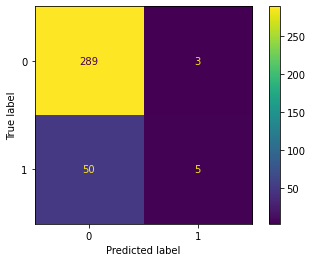

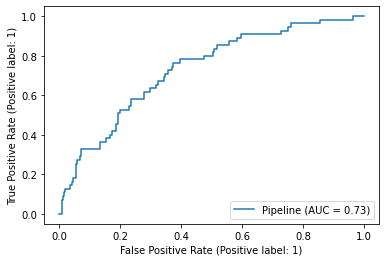

In [19]:
#unweighted logistic regression
logistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
logistic.fit(X_train, y_train)
print(f'model accuracy score: {logistic.score(X_test, y_test)}')

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 

plot_confusion_matrix(logistic, X_test, y_test)
plt.show()

from sklearn.metrics import plot_roc_curve


plot_roc_curve(logistic, X_test, y_test)  
plt.show()

## Even though overall accuracy is 84%, we only correctly identify 5 of the 55 red projects

model accuracy score: 0.7262247838616714


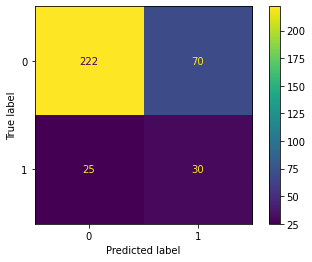

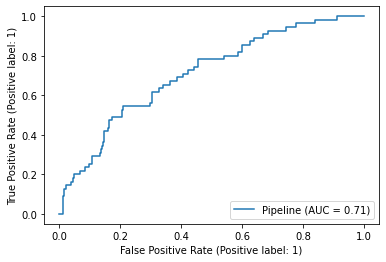

In [20]:
#weighted logistic regression
logistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight = 'balanced'))])
logistic.fit(X_train, y_train)
print(f'model accuracy score: {logistic.score(X_test, y_test)}')

plot_confusion_matrix(logistic, X_test, y_test)

plt.show()

plot_roc_curve(logistic, X_test, y_test)  
plt.show()

## Weighting the responses hurts overall accuracy, but improves the identification of reds to 30 out of 55. Still not great.

model accuracy score: 0.8414985590778098


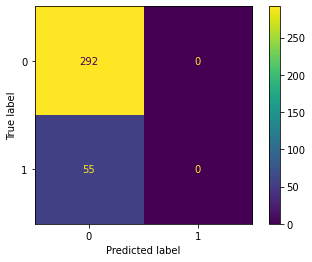

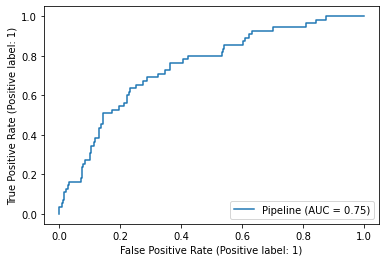

In [21]:
#Scikit's SVM models also allow for weighting

#unweighted Support Vector Machine
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
svm.fit(X_train, y_train)
print(f'model accuracy score: {svm.score(X_test, y_test)}')

#This model is even worse for overestimating greens - classifies everything as green!
plot_confusion_matrix(svm, X_test, y_test)
plt.show()
plot_roc_curve(svm, X_test, y_test)  
plt.show()

model accuracy score: 0.7809798270893372


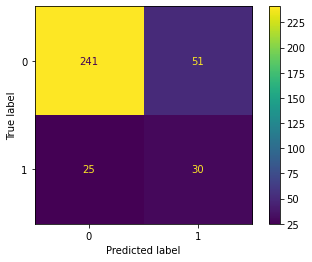

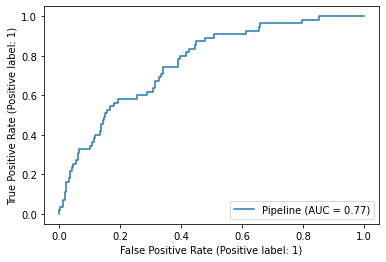

In [22]:
#weighted Support Vector Machine
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(class_weight='balanced'))])
svm.fit(X_train, y_train)
print(f'model accuracy score: {svm.score(X_test, y_test)}')

#Similar results to the weighted logistic regression, slightly better - not as many false negatives
plot_confusion_matrix(svm, X_test, y_test)
plt.show()
plot_roc_curve(svm, X_test, y_test)  
plt.show()

## One option to improve performance is to oversample the underrepresented class (reds)

model accuracy score: 0.8011527377521613


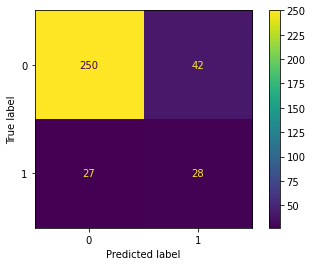

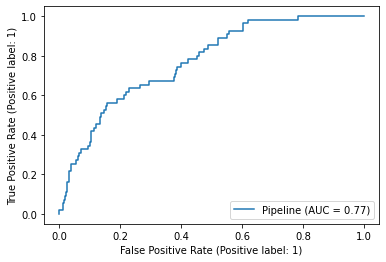

In [23]:
#Dependency to oversample the red projects 

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()

#This will oversample the reds so that there are an equal number of reds and greens in the training data
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


#Test results on unweighted svm (weighting would not affect this since the classes are 50/50 now)
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

svm.fit(X_resampled, y_resampled)
print(f'model accuracy score: {svm.score(X_test, y_test)}')

#Similar results to the weighted models
plot_confusion_matrix(svm, X_test, y_test)
plt.show
plot_roc_curve(svm, X_test, y_test)  
plt.show()

model accuracy score: 0.7377521613832853


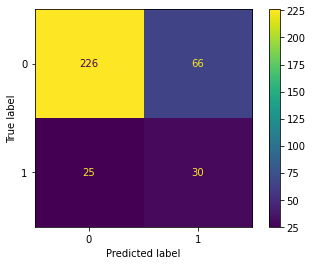

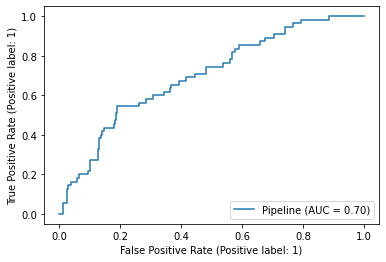

In [24]:
#Try the logistic regression again with oversampling
logistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

logistic.fit(X_resampled, y_resampled)
print(f'model accuracy score: {logistic.score(X_test, y_test)}')

plot_confusion_matrix(logistic, X_test, y_test)
plt.show()
plot_roc_curve(logistic, X_test, y_test)  
plt.show()

SVC()
model score: 0.8011527377521613


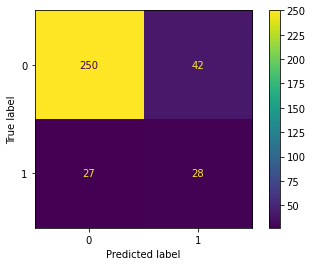

LogisticRegression()
model score: 0.7377521613832853


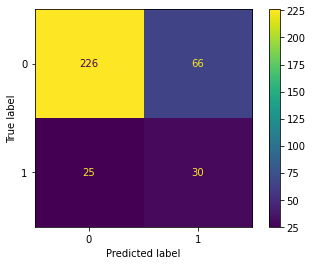

KNeighborsClassifier(n_neighbors=10)
model score: 0.7492795389048992


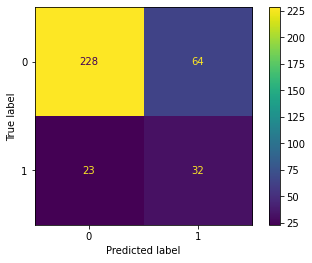

DecisionTreeClassifier()
model score: 0.7521613832853026


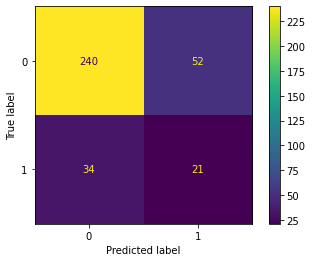

RandomForestClassifier()
model score: 0.8126801152737753


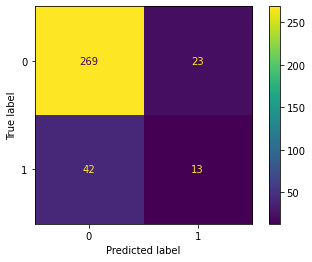

GradientBoostingClassifier()
model score: 0.7521613832853026


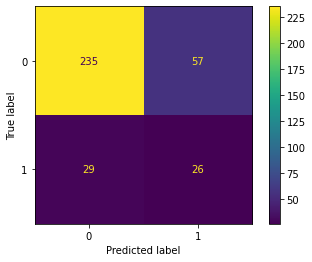

In [25]:
#Try the gauntlet again with oversampling

classifiers = [
    SVC(),
    LogisticRegression(),
    KNeighborsClassifier(10),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_resampled, y_resampled)   
    print(classifier)
    print(f'model score: {pipe.score(X_test, y_test)}')
    plot_confusion_matrix(pipe, X_test, y_test)
    plt.show()

## Choosing a model

### The best model given the current population seems to be the SVM fitted on the non-resampled training data, drawing decision threshold based on weight of classes

### Seems to be the best mix of accurately identifying the reds (around 50% of reds identified) and misclassifying fewer greens as red (around 15-20% of greens misidentified as red)

### In practice, we want to identify the projects that are likely to go red so that we can devote resources to them, but we don't want to misclassify too many green projects into the mix, as they would take resources away from the actual high-risk projects


model accuracy score: 0.7809798270893372


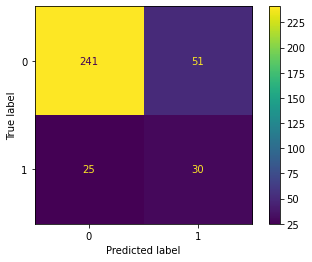

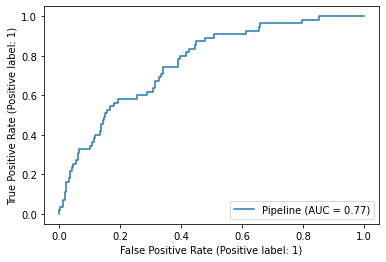

In [26]:
#rebuilding here for clarity
svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(probability = True, class_weight = 'balanced'))])
svm.fit(X_train, y_train)
print(f'model accuracy score: {svm.score(X_test, y_test)}')
plot_confusion_matrix(svm, X_test, y_test)
plt.show()
plot_roc_curve(svm, X_test, y_test)  
plt.show()

## Applying the model

### We can use the selected model to predict the final on-time status of active projects. We can view the prediction as a way to identify projects that are a higher risk of finishing development late due to some or a combination of their characteristics such as the district, the type of work, or who the project is administered by.

### This information could be used by project managers trying to balance where they devote the most time in their portfolio, or to make informed decisions as to which project manager should be overseeing the project (if applied to unassigned projects).

### This is by no means intended to be used as a sole decision making factor, but one piece of information to consider among all others.

In [27]:
#Add the project completed flag back in to the original dataframe so we can run predictions on all projects
none = dev_df['START_DLVR_84_ACT_END_DT'].fillna('none')

#list comprehension to map the new list to a binary and add to the trimmed df
dev_df['COMPLETED_DEV'] = [0 if x == 'none'  else 1 for x in none]


#trim the columns down to model parameters so that we can make predictions
pred_df_trimmed = dev_df[completed_df.columns].drop(columns = ['ON_TIME_STATUS', 'COMPLETED_DEV'])
pred_df_trimmed.head(3)

,ROAD_SYSTEM,SCOPE_OF_WORK,ADMINISTERED_BY,RESIDENCY,DISTRICT,MPO,PROGRAM_MANAGER,SMART_SCALE_INDICATOR,SMARTSCALE_COHORT,STATE_OF_GOOD_REPAIR_INDICATOR,BUDGET,ESTIMATE
0,Secondary,Bridge Replacement w/ Added Capacity,VDOT,EDINBURG,Staunton,NonMPO:NonMPO,Infrastructure Investment Division,0,NaN,0,4355591.0,4355591.0
1,Primary,Facilities for Pedestrians and Bicycles,Locally,FAIRFAX,Northern Virginia,Northern Virginia:Fairfax County,Infrastructure Investment Division,0,NaN,0,3120000.0,2646633.0
2,Miscellaneous,Facilities for Pedestrians and Bicycles,Locally,MANASSAS,Northern Virginia,Northern Virginia:Prince William County,Infrastructure Investment Division,0,NaN,0,750000.0,750000.0


In [28]:
#initiate lists to hold the predictions and probabilities

#Note that the probability threshold to classify a project as red is not 50% as it would be in an unweighted model
#Weighting the classes means the actual threshold is somewhere around 16%, similar to the proportion of reds in the population
#So, if the probability is over around 16%, the model is predicting "Red"

preds = []
probs = []

#loop through all projects and make predictions, save the outputs to the two lists
for x in pred_df_trimmed.index:
    preds.append(svm.predict(pred_df_trimmed.loc[x:x])[0])
    probs.append(svm.predict_proba(pred_df_trimmed.loc[x:x])[0][1])

#Add the lists of predictions and probabilities back to the table
dev_df['Prediction'] = preds
dev_df['Probability of Red'] = probs

dev_df.head(3)

,UPC,DESCRIPTION,ROUTE,ROAD_SYSTEM,SCOPE_OF_WORK,ADMINISTERED_BY,CITY_COUNTY,RESIDENCY,DISTRICT,MPO,...,START_DLVR_84_PLND_END_DT,START_DLVR_84_ACT_END_DT,START_DELIVERY_84_STATUS,DASHBOARD_COMMENT,GENERATED_DATE,REFRESHED_DATE,ACCOMPLISHMENT,COMPLETED_DEV,Prediction,Probability of Red
0,98956,RTE 761 ??? Replace Bridge 05453 & Appr over O...,0761,Secondary,Bridge Replacement w/ Added Capacity,VDOT,Clarke County,EDINBURG,Staunton,NonMPO:NonMPO,...,2024-04-30,NaT,G,NaN,2021-02-21 11:00:12,2021-02-21 06:04:15,RAAP CONTRACT,0,0,0.063439
1,103262,Tyson East Sidewalk South Side of Route 123 -...,0123,Primary,Facilities for Pedestrians and Bicycles,Locally,Fairfax County,FAIRFAX,Northern Virginia,Northern Virginia:Fairfax County,...,2020-06-22,2019-04-15,G,NaN,2021-02-21 11:00:12,2021-02-21 06:04:15,NON VDOT,1,0,0.079800
2,106490,POTOMAC HERITAGE TRAIL AT FEATHERSTONE WILDLIF...,0006,Miscellaneous,Facilities for Pedestrians and Bicycles,Locally,Prince William County,MANASSAS,Northern Virginia,Northern Virginia:Prince William County,...,2019-04-30,NaT,R,Project advertisement is still underway,2021-02-21 11:00:12,2021-02-21 06:04:15,NON VDOT,0,1,0.213881


In [29]:
#Save the table to an excel document
dev_df.to_excel('dev_projects_w_OT_predictions.xlsx')

# Results and Interpretation

### Using a Support Vector Machine (SVM) and weighting the response classes, we ended up with a model that is able to correctly identify around 50% of the projects that will finish the development process late. This sounds like a coin flip, but considering that only 16% of projects finish red, being able to correctly predict the outcome for half of them is not bad. Unfortunately, for each red project that the model correctly predicts, it also mistakenly predicts that two other green projects will be red. There are improvements to be made, but the results are promising for applying an out-of-the-box model to the data with little data preparation or model tuning.

# Takeaways and Improvements

### Clearly, only using attributes about the project location, type of work, and other details is not enough to reliably identify projects that are likely to finish development late. I believe that lateness is driven largely by the schedule set out during scoping, so including information about the planned duration of development, which milestones are present in the template, and other information about the timeline of a project would be a large benefit to the predictive power of the model. There is also the possibility of including information about the life-to-date milestone performance of the project and how far into the development process the project is, which would give more information about a project's likelihood of finishing late.

### Even without looking at milestones and durations, there is room to improve the model by tuning the hyperparameters of the support vector machine, as well as selecting the appropriate attributes to use in the predictive model.

### Another major consideration is that the development process can be impacted by many external factors that will not be related to the project information. However, with enough historical data, I believe that a model could be able to see past that and recognize which types of projects are more likely to be impacted by these external factors, based on how similar projects have finished development late.

### Ultimately, this was an interesting challenge and an excellent learning experience. I enjoyed working on this exercise and hope to have the opportunity to do this type of work in the future. 